# Analyze predictions

In [2]:
import pandas as pd
import wandb
import json
from src.evaluation import RankingEvaluator
from datasets import load_from_disk
from src.utils.config_management import CONFIG
import matplotlib.pyplot as plt

In [3]:
hf_dataset = load_from_disk(CONFIG['paths']['data']['dalip_hf_dataset'])
test_dataset_df = pd.DataFrame(hf_dataset['test'])

In [4]:
api = wandb.Api()

## Load predictions

In [5]:
RUN_ID = 'pe1glus9'
RUN_PATH = f'bunnynobugs/dalip-stackoverflow-answer-ranking/{RUN_ID}'
STEP = 7740

In [6]:
run = api.run(RUN_PATH)

In [7]:
%%time

history = run.scan_history()
history_df = pd.DataFrame(history)

Wall time: 24.1 s


In [8]:
eval_history_df = history_df[history_df['eval/loss'].notna()]
PREDICTIONS_TABLE_VERSION = eval_history_df.index.get_loc(
    eval_history_df[eval_history_df['train/global_step'] == STEP].index[0])

In [9]:
ARTIFACT_PATH = f'bunnynobugs/dalip-stackoverflow-answer-ranking/run-{RUN_ID}-predictions_table:v{PREDICTIONS_TABLE_VERSION}'
ARTIFACT_NAME = ARTIFACT_PATH.split('/')[-1].replace(':', '-')
ARTIFACT_DOWNLOAD_PATH = f'wandb/wandb_artifacts/{ARTIFACT_NAME}'

In [10]:
artifact = api.artifact(ARTIFACT_PATH)

In [11]:
artifact.download(root=ARTIFACT_DOWNLOAD_PATH)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


'wandb/wandb_artifacts/run-pe1glus9-predictions_table-v2'

In [12]:
with open(f'{ARTIFACT_DOWNLOAD_PATH}/predictions_table.table.json') as f:
    predictions_table = json.load(f)

In [13]:
predictions_df = pd.DataFrame(predictions_table['data'], columns=predictions_table['columns'])
predictions_df = predictions_df.merge(test_dataset_df[['answer_id', 'question_id']], on='answer_id')

## Analyze predictions

In [14]:
predictions_df['predicted_score'].describe()

count    10563.000000
mean        -0.265582
std          1.122810
min         -3.771840
25%         -1.057039
50%         -0.285249
75%          0.499505
max          4.195727
Name: predicted_score, dtype: float64

<Axes: >

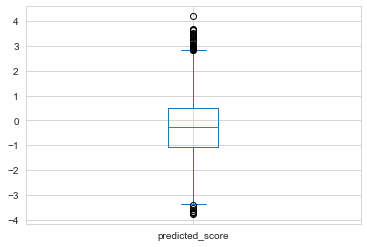

In [15]:
predictions_df['predicted_score'].plot.box()

## Metrics per group

In [16]:
evaluator = RankingEvaluator(ndcg_k=list(range(1, 11)),
                             ndcg_gain_func='exponential', ndcg_discount_func='logarithmic',
                             return_metrics_per_group=True)

In [17]:
metrics, metrics_per_group = evaluator(
    predictions_df['answer_normalized_score'], predictions_df['predicted_score'], predictions_df['question_id'])
metrics_per_group_df = pd.DataFrame(metrics_per_group)
metrics_per_group_df = metrics_per_group_df.rename(columns={'group_id': 'question_id'})

In [18]:
metrics

{'ndcg@1_g.exponential_d.logarithmic': 0.5402363675927209,
 'ndcg@2_g.exponential_d.logarithmic': 0.639595610229857,
 'ndcg@3_g.exponential_d.logarithmic': 0.710823484268227,
 'ndcg@4_g.exponential_d.logarithmic': 0.7625289351800709,
 'ndcg@5_g.exponential_d.logarithmic': 0.7862172335147282,
 'ndcg@6_g.exponential_d.logarithmic': 0.7950545738305694,
 'ndcg@7_g.exponential_d.logarithmic': 0.7993379086046274,
 'ndcg@8_g.exponential_d.logarithmic': 0.8015196343938722,
 'ndcg@9_g.exponential_d.logarithmic': 0.8026930583702595,
 'ndcg@10_g.exponential_d.logarithmic': 0.8033659511617566,
 'mae': 18.70693350507834,
 'hit_rate@1': 0.4272493573264782}

In [19]:
metrics_per_group_df.describe()

,question_id,ndcg@1_g.exponential_d.logarithmic,ndcg@2_g.exponential_d.logarithmic,ndcg@3_g.exponential_d.logarithmic,ndcg@4_g.exponential_d.logarithmic,ndcg@5_g.exponential_d.logarithmic,ndcg@6_g.exponential_d.logarithmic,ndcg@7_g.exponential_d.logarithmic,ndcg@8_g.exponential_d.logarithmic,ndcg@9_g.exponential_d.logarithmic,ndcg@10_g.exponential_d.logarithmic,hit_rate@1
count,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03,1945.000000
mean,3.676443e+06,5.402364e-01,6.395956e-01,7.108235e-01,7.625289e-01,7.862172e-01,7.950546e-01,7.993379e-01,8.015196e-01,8.026931e-01,8.033660e-01,0.427249
std,2.732398e+06,4.224762e-01,3.429882e-01,2.931432e-01,2.535331e-01,2.259595e-01,2.137530e-01,2.061492e-01,2.018492e-01,1.991565e-01,1.971134e-01,0.494806
min,6.960000e+02,2.430865e-63,1.005153e-58,1.005154e-58,2.811301e-55,2.811310e-55,2.811311e-55,2.811311e-55,2.811311e-55,2.811311e-55,2.811311e-55,0.000000
25%,1.260040e+06,1.249983e-01,3.521802e-01,5.621953e-01,6.312350e-01,6.397844e-01,6.483611e-01,6.526524e-01,6.536873e-01,6.539851e-01,6.539851e-01,0.000000
50%,3.072421e+06,4.999981e-01,6.934261e-01,7.731554e-01,8.173715e-01,8.403405e-01,8.503553e-01,8.558096e-01,8.583204e-01,8.583204e-01,8.583204e-01,0.000000
75%,5.861428e+06,1.000000e+00,9.975475e-01,9.854065e-01,9.896416e-01,9.920465e-01,9.927169e-01,9.927169e-01,9.927169e-01,9.927169e-01,9.927169e-01,1.000000
max,9.692987e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000


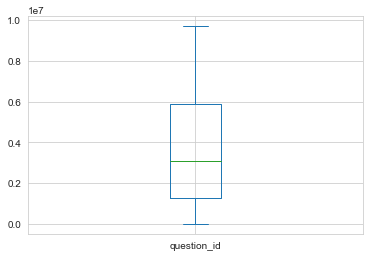

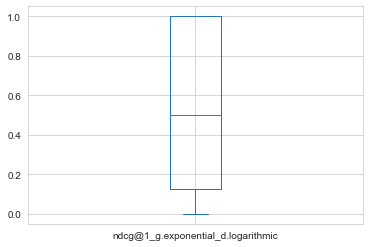

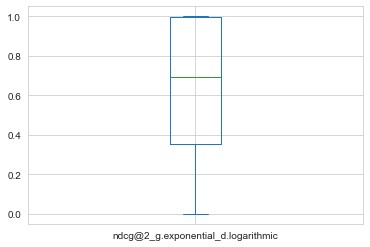

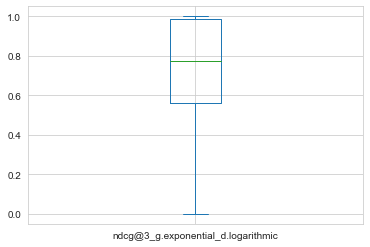

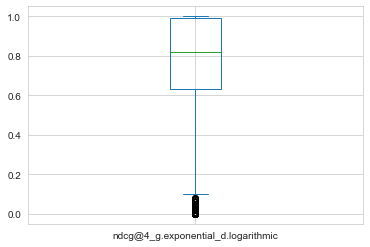

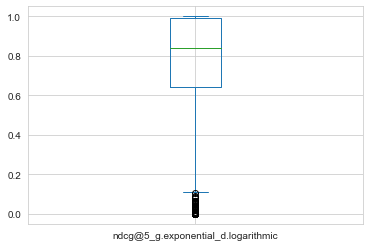

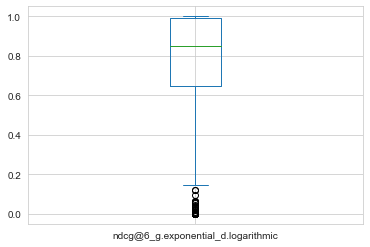

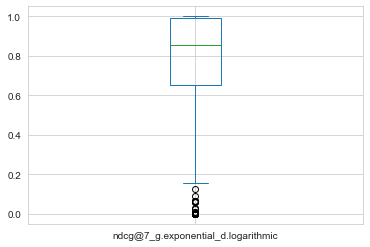

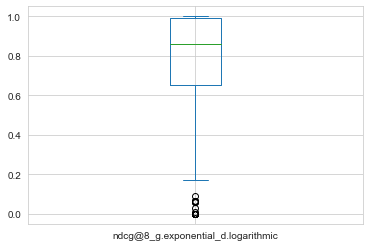

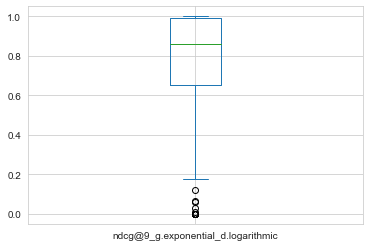

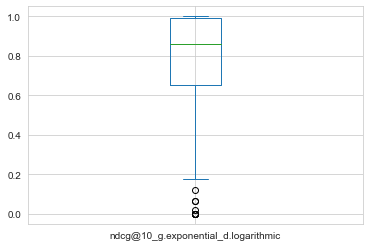

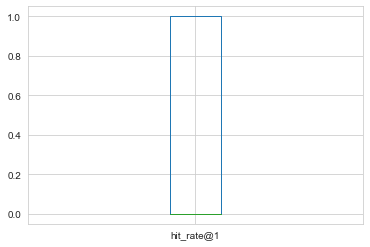

In [20]:
for col in metrics_per_group_df.columns:
    metrics_per_group_df[col].plot.box()
    plt.show()

### Metrics correlation with answer scores distribution

In [21]:
test_questions_df = pd.read_csv('data/dalip_stackoverflow_dataset/test_answer_scores_distribution.csv')
test_questions_df = test_questions_df.merge(metrics_per_group_df, on='question_id')

In [22]:
test_questions_df.corr()

,question_id,answer_scores_range,answer_scores_std,diff_gap_1,diff_gap_2,diff_gap_3,diff_gap_4,pct_gap_1,pct_gap_2,pct_gap_3,...,ndcg@2_g.exponential_d.logarithmic,ndcg@3_g.exponential_d.logarithmic,ndcg@4_g.exponential_d.logarithmic,ndcg@5_g.exponential_d.logarithmic,ndcg@6_g.exponential_d.logarithmic,ndcg@7_g.exponential_d.logarithmic,ndcg@8_g.exponential_d.logarithmic,ndcg@9_g.exponential_d.logarithmic,ndcg@10_g.exponential_d.logarithmic,hit_rate@1
question_id,1.000000,-0.194206,-0.186840,-0.150413,-0.157828,-0.188171,-0.142524,-0.169654,-0.157673,-0.183824,...,0.121135,0.132989,0.161394,0.171200,0.169624,0.165253,0.161231,0.159660,0.159680,0.056174
answer_scores_range,-0.194206,1.000000,0.934259,0.937687,0.749635,0.550500,0.457295,0.702807,0.591787,0.409513,...,-0.127682,-0.157149,-0.195872,-0.216202,-0.226859,-0.231190,-0.233461,-0.234146,-0.230519,-0.029402
answer_scores_std,-0.186840,0.934259,1.000000,0.897628,0.793252,0.498779,0.347093,0.716069,0.696266,0.437716,...,-0.108250,-0.127703,-0.159033,-0.176651,-0.186825,-0.192274,-0.194591,-0.195693,-0.193698,-0.011166
diff_gap_1,-0.150413,0.937687,0.897628,1.000000,0.560616,0.370457,0.242985,0.842271,0.436142,0.284124,...,-0.060728,-0.084891,-0.121931,-0.139814,-0.149560,-0.154483,-0.157166,-0.159859,-0.157129,0.004556
diff_gap_2,-0.157828,0.749635,0.793252,0.560616,1.000000,0.404552,0.374615,0.254151,0.942428,0.309550,...,-0.143113,-0.152741,-0.166654,-0.174957,-0.183130,-0.185726,-0.187513,-0.186996,-0.184085,-0.033075
diff_gap_3,-0.188171,0.550500,0.498779,0.370457,0.404552,1.000000,0.391482,0.219865,0.240081,0.934509,...,-0.160723,-0.185877,-0.195921,-0.212200,-0.224367,-0.230382,-0.230571,-0.230066,-0.231485,-0.076634
diff_gap_4,-0.142524,0.457295,0.347093,0.242985,0.374615,0.391482,1.000000,0.119961,0.164621,0.141959,...,-0.108825,-0.128895,-0.157784,-0.187815,-0.196550,-0.204831,-0.210040,-0.215102,-0.213758,-0.051517
pct_gap_1,-0.169654,0.702807,0.716069,0.842271,0.254151,0.219865,0.119961,1.000000,0.214302,0.195636,...,-0.052101,-0.074572,-0.125129,-0.145419,-0.155169,-0.160830,-0.163335,-0.166596,-0.164156,0.009545
pct_gap_2,-0.157673,0.591787,0.696266,0.436142,0.942428,0.240081,0.164621,0.214302,1.000000,0.225548,...,-0.141928,-0.140858,-0.148950,-0.153867,-0.160617,-0.162021,-0.163630,-0.162309,-0.160664,-0.026003
pct_gap_3,-0.183824,0.409513,0.437716,0.284124,0.309550,0.934509,0.141959,0.195636,0.225548,1.000000,...,-0.144805,-0.162287,-0.165689,-0.176463,-0.186267,-0.191171,-0.190865,-0.190039,-0.191598,-0.067641


### Metrics correlation with question tags

In [64]:
import re
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from scipy.stats import mannwhitneyu

In [89]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [60]:
NDCG_COL = 'ndcg@1_g.exponential_d.logarithmic'

In [25]:
test_questions_df = test_dataset_df.drop_duplicates('question_id')
test_questions_df = test_questions_df.merge(metrics_per_group_df, on='question_id')

In [26]:
test_questions_df['question_len'] = test_questions_df['question_body'].apply(len)

In [27]:
test_questions_df['question_tags'] = test_questions_df['question_tags'].apply(lambda x: re.findall(r'<([^>]+)>', x))

In [28]:
all_question_tags = []
for question_tags in test_questions_df['question_tags']:
    all_question_tags.extend(question_tags)
all_question_tags = pd.Series(all_question_tags)

In [75]:
all_question_tags.value_counts()[:30]

c#                278
java              253
c++               176
php               158
javascript        156
.net              111
jquery            104
python             94
html               88
sql                88
c                  82
mysql              74
asp.net            74
css                66
string             48
sql-server         47
regex              41
iphone             41
algorithm          40
arrays             38
android            36
performance        35
linux              32
objective-c        29
oop                28
database           27
windows            27
tsql               21
multithreading     20
xml                20
dtype: int64

In [31]:
top_tags = set(all_question_tags.value_counts().index[:10])

In [32]:
test_questions_df['tags_in_top'] = test_questions_df['question_tags'].apply(lambda x: top_tags.intersection(x))
test_questions_df['n_tags_in_top'] = test_questions_df['tags_in_top'].apply(len)

In [33]:
test_questions_df['n_tags_in_top'].value_counts()

1    1056
0     676
2     190
3      22
4       1
Name: n_tags_in_top, dtype: int64

In [34]:
def get_top_tag(tags):
    for tag in tags:
        if tag in top_tags:
            return tag
    else:
        return None

In [35]:
test_questions_df['top_tag'] = test_questions_df['question_tags'].apply(get_top_tag)

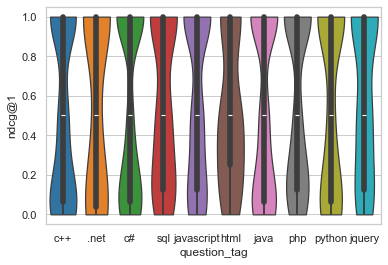

In [91]:
ax = sns.violinplot(data=test_questions_df.rename(columns={'top_tag': 'question_tag', NDCG_COL: 'ndcg@1'}),
            x='question_tag', y='ndcg@1', hue='question_tag',
            cut=0, legend=False)
ax.get_figure().savefig('outputs/images/top_tags.pdf')

In [80]:
test_questions_df.groupby('top_tag')[NDCG_COL].mean()

top_tag
.net          0.553619
c#            0.533927
c++           0.499475
html          0.511404
java          0.520867
javascript    0.566107
jquery        0.594546
php           0.562775
python        0.556034
sql           0.556584
Name: ndcg@1_g.exponential_d.logarithmic, dtype: float64

In [42]:
mlb = MultiLabelBinarizer()
tags_one_hot_df = pd.DataFrame(mlb.fit_transform(test_questions_df['question_tags']), columns=mlb.classes_)
test_questions_df = test_questions_df.join(tags_one_hot_df)

In [83]:
significant_tags_df = []
top_tags_df = []

for tag in tags_one_hot_df.columns:
    ndcg_with_tag = test_questions_df[test_questions_df[tag] == 1][NDCG_COL]
    ndcg_without_tag = test_questions_df[test_questions_df[tag] == 0][NDCG_COL]

    u_statistic, pvalue = mannwhitneyu(ndcg_with_tag, ndcg_without_tag, alternative='two-sided')

    if pvalue < 0.05:
        significant_tags_df.append({
            'tag': tag,
            'n_with_tag': len(ndcg_with_tag),
            'n_without_tag': len(ndcg_without_tag),
            'u_statistic': u_statistic,
            'p_value': pvalue,
            'mean_ndcg_with_tag': f'{ndcg_with_tag.mean():.4f}'[:-1],
            'mean_ndcg_without_tag': f'{ndcg_without_tag.mean():.4f}'[:-1]
        })

    if tag in top_tags:
        top_tags_df.append({
            'tag': tag,
            'n_with_tag': len(ndcg_with_tag),
            'n_without_tag': len(ndcg_without_tag),
            'mean_ndcg_with_tag': f'{ndcg_with_tag.mean():.4f}'[:-1],
            'mean_ndcg_without_tag': f'{ndcg_without_tag.mean():.4f}'[:-1]
        })

significant_tags_df = pd.DataFrame(significant_tags_df)
top_tags_df = pd.DataFrame(top_tags_df)

In [92]:
significant_tags_df

,tag,n_with_tag,n_without_tag,u_statistic,p_value,mean_ndcg_with_tag,mean_ndcg_without_tag
0,architecture,2,1943,276.0,0.028747,0.007,0.540
1,asp.net,74,1871,78252.0,0.047250,0.622,0.537
2,attributes,2,1943,218.5,0.023673,0.003,0.540
3,coding-style,11,1934,5411.0,0.003381,0.213,0.542
4,command-line,7,1938,9658.0,0.043496,0.875,0.539
5,comparison,3,1942,394.0,0.006950,0.005,0.541
6,concurrency,5,1940,1828.5,0.012098,0.126,0.541
7,data-binding,5,1940,7635.0,0.020732,1.000,0.539
8,django,10,1935,5655.0,0.018088,0.221,0.541
9,google,2,1943,384.5,0.040899,0.007,0.540


In [84]:
significant_tags_df[significant_tags_df['n_with_tag'] >= 10]

,tag,n_with_tag,n_without_tag,u_statistic,p_value,mean_ndcg_with_tag,mean_ndcg_without_tag
1,asp.net,74,1871,78252.0,0.047250,0.622,0.537
3,coding-style,11,1934,5411.0,0.003381,0.213,0.542
8,django,10,1935,5655.0,0.018088,0.221,0.541
11,linux,32,1913,39820.0,0.002322,0.750,0.536
13,multithreading,20,1925,14478.5,0.046688,0.353,0.542
16,regex,41,1904,47466.5,0.013534,0.691,0.537
23,unit-testing,17,1928,10741.0,0.010728,0.321,0.542


In [85]:
significant_tags_df[significant_tags_df['n_with_tag'] >= 10].to_csv('outputs/tables/significant_tags.csv', index=False)

In [87]:
top_tags_df

,tag,n_with_tag,n_without_tag,mean_ndcg_with_tag,mean_ndcg_without_tag
0,.net,111,1834,0.523,0.541
1,c#,278,1667,0.533,0.541
2,c++,176,1769,0.497,0.544
3,html,88,1857,0.513,0.541
4,java,253,1692,0.527,0.542
5,javascript,156,1789,0.563,0.538
6,jquery,104,1841,0.577,0.538
7,php,158,1787,0.562,0.538
8,python,94,1851,0.543,0.540
9,sql,88,1857,0.552,0.539


In [88]:
top_tags_df.to_csv('outputs/tables/top_tags.csv', index=False)